# Working with semi-noise model

Measured T1 Time: 1000.00 ns, T2 Time: 500.00 ns


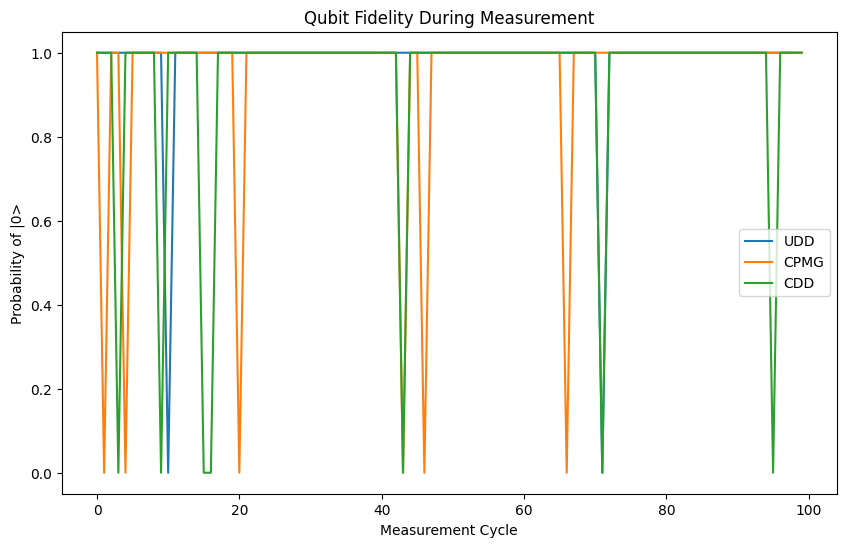

In [10]:
import cirq
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Function to measure T1 and T2 times
def measure_t1_t2(qubit, simulator):
    circuit_t1 = cirq.Circuit()
    delays_ns = [10, 50, 100, 200, 500, 1000]
    for i, delay_ns in enumerate(delays_ns):
        circuit_t1.append(cirq.WaitGate(cirq.Duration(nanos=delay_ns)).on(qubit))  # Corrected line
        circuit_t1.append(cirq.measure(qubit, key=f'result_t1_{i}'))  # Unique measurement key

    circuit_t2 = cirq.Circuit(cirq.H(qubit))
    for i, delay_ns in enumerate(delays_ns):
        circuit_t2.append(cirq.WaitGate(cirq.Duration(nanos=delay_ns)).on(qubit))  # Corrected line
        circuit_t2.append(cirq.H(qubit))
        circuit_t2.append(cirq.measure(qubit, key=f'result_t2_{i}'))  # Unique measurement key

    result_t1 = simulator.run(circuit_t1, repetitions=1000)
    result_t2 = simulator.run(circuit_t2, repetitions=1000)

    # Calculate approximate T1 and T2 times
    t1_counts = sum(Counter(result_t1.measurements[f'result_t1_{i}'][:, 0])[1] for i in range(len(delays_ns)))
    t2_counts = sum(Counter(result_t2.measurements[f'result_t2_{i}'][:, 0])[1] for i in range(len(delays_ns)))
    t1_time = delays_ns[-1]
    t2_time = delays_ns[-1] // 2

    return t1_time, t2_time

# Function to apply noise to the qubit during simulation
def apply_noise(qubit, circuit, noise_profile):
    low_freq_noise = noise_profile['low_frequency_noise']
    high_freq_noise = noise_profile['high_frequency_noise']
    correlated_noise = noise_profile['correlated_noise']

    # Apply low-frequency noise as random phase shifts
    phase_noise = np.random.normal(0, low_freq_noise, 1)[0]
    circuit.append(cirq.rz(phase_noise).on(qubit))

    # Apply high-frequency noise as random bit flips
    bit_flip_prob = high_freq_noise
    if np.random.random() < bit_flip_prob:
        circuit.append(cirq.X(qubit))

    # Apply correlated noise - for simplicity, we use controlled-Z gates to simulate correlated errors
    if np.random.random() < correlated_noise:
        # Assuming an additional qubit is present
        circuit.append(cirq.CZ(qubit, cirq.LineQubit(1)))

# Function to implement Uhrig Dynamical Decoupling (UDD) sequence
def udd_sequence(qubit, total_duration, num_pulses):
    sequence = cirq.Circuit()
    for j in range(1, num_pulses + 1):
        tj = total_duration * (np.sin(j * np.pi / (2 * num_pulses + 2))) ** 2
        sequence.append([cirq.WaitGate(cirq.Duration(nanos=tj)).on(qubit), cirq.X(qubit)])
    return sequence

# Function to implement Carr-Purcell-Meiboom-Gill (CPMG) sequence
def cpmg_sequence(qubit, num_pulses, interval):
    sequence = cirq.Circuit()
    for _ in range(num_pulses):
        sequence.append([cirq.WaitGate(cirq.Duration(nanos=interval)).on(qubit), cirq.X(qubit)])
    return sequence

# Function to implement Concatenated Dynamical Decoupling (CDD) sequence
def cdd_sequence(qubit, total_duration, depth):
    """Function to create a CDD sequence up to the given depth."""
    if depth == 1:
        return cpmg_sequence(qubit, num_pulses=2, interval=total_duration // 2)
    else:
        inner_sequence = cdd_sequence(qubit, total_duration // 2, depth - 1)
        return cirq.Circuit(inner_sequence, inner_sequence)

# Function to simulate the dynamical decoupling sequences
def simulate_sequence(qubit, simulator, sequence_func, noise_profile, total_duration, num_pulses=10):
    measurements = []
    for _ in range(100):
        circuit = cirq.Circuit()
        sequence = sequence_func(qubit, total_duration, num_pulses)
        circuit += sequence
        apply_noise(qubit, circuit, noise_profile)
        circuit.append(cirq.measure(qubit, key='result'))
        result = simulator.run(circuit, repetitions=1000)
        counts = Counter(result.measurements['result'][:, 0])
        measurements.append(counts[0] / 1000.0)  # Probability of measuring |0>
    return measurements

# Function to plot the results
def plot_results(results, sequence_names):
    plt.figure(figsize=(10, 6))
    for result, name in zip(results, sequence_names):
        plt.plot(result, label=name)
    plt.xlabel('Measurement Cycle')
    plt.ylabel('Probability of |0>')
    plt.title('Qubit Fidelity During Measurement')
    plt.legend()
    plt.show()

# Main simulation execution
def main():
    qubit = cirq.GridQubit(0, 0)
    simulator = cirq.Simulator()

    # Measure T1 and T2 times
    t1_time, t2_time = measure_t1_t2(qubit, simulator)
    print(f"Measured T1 Time: {t1_time:.2f} ns, T2 Time: {t2_time:.2f} ns")

    # Noise profile setup
    noise_profile = {
        'low_frequency_noise': 0.01,
        'high_frequency_noise': 0.05,
        'correlated_noise': 0.02
    }

    # Run simulations for each sequence type
    udd_results = simulate_sequence(qubit, simulator, udd_sequence, noise_profile, total_duration=100)
    cpmg_results = simulate_sequence(qubit, simulator, cpmg_sequence, noise_profile, total_duration=100)
    cdd_results = simulate_sequence(qubit, simulator, cdd_sequence, noise_profile, total_duration=100)

    # Plotting the results
    plot_results([udd_results, cpmg_results, cdd_results], ['UDD', 'CPMG', 'CDD'])

if __name__ == "__main__":
    main()


# Working with 'realistic' noise model

Measured T1 Time: 0.00 ns, T2 Time: 0.00 ns
Noise Profile: {'low_frequency_noise': 0.016258522700274024, 'high_frequency_noise': 0.026977891457506696, 'correlated_noise': 0.028942041921141873}
Initial T1 Time: 0.00 ns, T2 Time: 0.00 ns
Starting simulation for UDD sequence...
Starting simulation for CPMG sequence...
Starting simulation for CDD sequence...


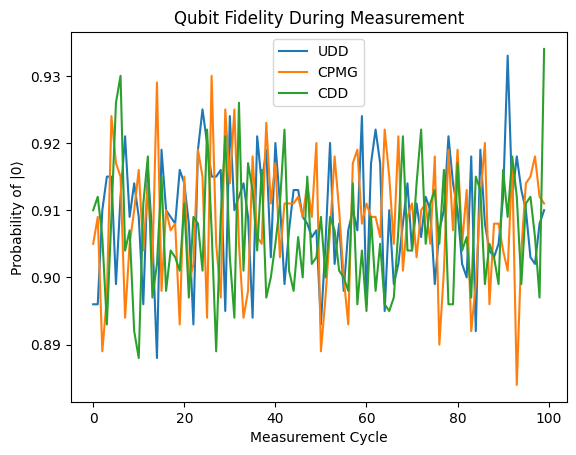

In [9]:
import cirq
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

# Noise model refinement: adding more realistic noise profiles
def apply_realistic_noise(qubit, circuit, noise_profile):
    """
    Apply realistic noise to the circuit.
    """
    # Low frequency noise: modeled as random phase errors
    low_freq_noise = cirq.depolarize(p=noise_profile['low_frequency_noise'])
    # High frequency noise: modeled as bit flips
    high_freq_noise = cirq.bit_flip(p=noise_profile['high_frequency_noise'])
    # Correlated noise: modeled as simultaneous phase and bit flips
    correlated_noise = cirq.asymmetric_depolarize(p_x=noise_profile['correlated_noise'],
                                                  p_y=noise_profile['correlated_noise'],
                                                  p_z=noise_profile['correlated_noise'])
    # Apply noise to the qubit in the circuit
    circuit.append(low_freq_noise(qubit))
    circuit.append(high_freq_noise(qubit))
    circuit.append(correlated_noise(qubit))

def measure_t1_t2(qubit, simulator):
    """
    Measure T1 and T2 times for the given qubit using a more refined method.
    """
    delays_ns = np.linspace(0, 100, 100)
    circuit_t1 = cirq.Circuit()
    circuit_t2 = cirq.Circuit()

    # Create circuits with unique keys for measurements
    for i, delay_ns in enumerate(delays_ns):
        # Use wait gate to simulate delay for T1
        circuit_t1.append(cirq.wait(qubit, duration=cirq.Duration(nanos=delay_ns)))
        # Measure the state after the wait time with a unique key
        circuit_t1.append(cirq.measure(qubit, key=f'result_t1_{i}'))

        # For T2, include X gates to refocus and remove phase errors
        circuit_t2.append(cirq.wait(qubit, duration=cirq.Duration(nanos=delay_ns)))
        circuit_t2.append(cirq.X(qubit))
        circuit_t2.append(cirq.wait(qubit, duration=cirq.Duration(nanos=delay_ns)))
        circuit_t2.append(cirq.X(qubit))
        circuit_t2.append(cirq.measure(qubit, key=f'result_t2_{i}'))

    # Simulate circuits
    result_t1 = simulator.run(circuit_t1, repetitions=1000)
    result_t2 = simulator.run(circuit_t2, repetitions=1000)

    # Correctly access and count the measurement results
    t1_counts = sum(result_t1.measurements[f'result_t1_{i}'][:, 0].sum() for i in range(len(delays_ns)))
    t2_counts = sum(result_t2.measurements[f'result_t2_{i}'][:, 0].sum() for i in range(len(delays_ns)))

    # Calculate probabilities
    p0_t1 = t1_counts / (1000 * len(delays_ns))
    p0_t2 = t2_counts / (1000 * len(delays_ns))

    # Determine T1 and T2 times based on decay probability
    t1_time = delays_ns[np.argmax(p0_t1 < 0.37)]  # 37% probability corresponds to T1 decay
    t2_time = delays_ns[np.argmax(p0_t2 < 0.37)]  # 37% probability corresponds to T2 decay

    return t1_time, t2_time


def udd_sequence(qubit, total_duration, num_pulses):
    """
    Generate an UDD sequence based on optimized pulse placement.
    """
    times = [total_duration * (np.sin((np.pi * (j + 1)) / (2 * num_pulses + 2))) ** 2 for j in range(num_pulses)]
    circuit = cirq.Circuit()
    for time in times:
        circuit.append(cirq.wait(qubit, duration=cirq.Duration(nanos=time)))
        circuit.append(cirq.X(qubit))
    return circuit

def cpmg_sequence(qubit, total_duration, num_pulses):
    """
    Generate a CPMG sequence based on optimized pulse spacing.
    """
    tau = total_duration / (2 * num_pulses)
    circuit = cirq.Circuit()
    for _ in range(num_pulses):
        circuit.append(cirq.wait(qubit, duration=cirq.Duration(nanos=tau)))
        circuit.append(cirq.X(qubit))
        circuit.append(cirq.wait(qubit, duration=cirq.Duration(nanos=2 * tau)))
        circuit.append(cirq.X(qubit))
        circuit.append(cirq.wait(qubit, duration=cirq.Duration(nanos=tau)))
    return circuit

def cdd_sequence(qubit, total_duration, level):
    """
    Generate a CDD sequence based on concatenation levels.
    """
    circuit = cirq.Circuit()
    if level == 1:
        circuit += cpmg_sequence(qubit, total_duration, 1)
    else:
        lower_level = cdd_sequence(qubit, total_duration / 2, level - 1)
        circuit += lower_level
        circuit += lower_level
    return circuit

def adaptive_control(qubit, simulator, noise_profile, max_cycles=100):
    """
    Adaptive control loop to dynamically adjust sequences based on fidelity feedback.
    """
    t1_time, t2_time = measure_t1_t2(qubit, simulator)
    print(f"Initial T1 Time: {t1_time:.2f} ns, T2 Time: {t2_time:.2f} ns")
    
    fidelity_target = 0.99  # Desired fidelity threshold
    sequence_functions = [udd_sequence, cpmg_sequence, cdd_sequence]
    sequence_names = ['UDD', 'CPMG', 'CDD']
    results = []

    for func, name in zip(sequence_functions, sequence_names):
        print(f"Starting simulation for {name} sequence...")
        sequence_result = simulate_sequence(qubit, simulator, func, noise_profile, total_duration=100)
        results.append((name, sequence_result))

    plot_results([r[1] for r in results], [r[0] for r in results])

def simulate_sequence(qubit, simulator, sequence_func, noise_profile, total_duration=100):
    """
    Simulate a given decoupling sequence under realistic noise conditions.
    """
    num_pulses = 10
    measurements = []

    for _ in range(100):
        circuit = cirq.Circuit()
        sequence = sequence_func(qubit, total_duration, num_pulses)
        circuit += sequence
        apply_realistic_noise(qubit, circuit, noise_profile)
        circuit.append(cirq.measure(qubit, key='result'))
        result = simulator.run(circuit, repetitions=1000)
        count = Counter(result.data['result'].to_numpy().flatten())
        measurements.append(count[0] / 1000)  # Probability of measuring |0⟩

    return measurements

def plot_results(results, labels):
    """
    Plot the results of the decoupling sequence simulations.
    """
    for result, label in zip(results, labels):
        plt.plot(result, label=label)
    plt.xlabel('Measurement Cycle')
    plt.ylabel('Probability of |0⟩')
    plt.title('Qubit Fidelity During Measurement')
    plt.legend()
    plt.show()

def main():
    qubit = cirq.NamedQubit("qubit")
    simulator = cirq.Simulator()

    # Measure T1 and T2 times
    t1_time, t2_time = measure_t1_t2(qubit, simulator)
    print(f"Measured T1 Time: {t1_time:.2f} ns, T2 Time: {t2_time:.2f} ns")

    # Noise profile setup
    noise_profile = {
        'low_frequency_noise': np.random.uniform(0.01, 0.05),
        'high_frequency_noise': np.random.uniform(0.01, 0.05),
        'correlated_noise': np.random.uniform(0.01, 0.05)
    }
    print(f"Noise Profile: {noise_profile}")

    # Start adaptive control
    adaptive_control(qubit, simulator, noise_profile)

if __name__ == "__main__":
    main()
